# Proyecto Final - Text Mining 2021
Garagiola Nazareno


In [ ]:
!python -m spacy download es_core_news_md

In [ ]:
import tweepy
import spacy
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [ ]:
#f = open('tweets.txt', 'r')
f = open('corpus.txt', 'r')
text = f.read()
text = text.split('\n')
corpus = list(set(text))
len(corpus)

12864

---
## Leer archivo

### TO DO


1.   Clasficar: bueno vs malo vs neutro con lsita de palabras de valoraicon
1.   Clustering sobre los 
1.   Buscar [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), hacer funcion e intentar implementar





In [ ]:
good_val = "top,gusta,buena,entretenida,zarpada,recomiendo,sarpada,buenisima,verla,tremenda,locura,buenarda,encanto,encanta".split(',')
bad_val = "horrendo,infumable,absurdo,absurda,mal,malo,malisimo,pesimo,pesima,chota,triste,horrible,mala,malita,fea,malisima,sobrevalorado,sobrevalorada,bosta,poronga".split(',')

## Procesamiento

In [ ]:
import spacy
nlp = spacy.load("es_core_news_md")

In [ ]:
words = list()
for tw in corpus:
    for w in tw.split(' '):
        words.append(w.lower())

counter = Counter(words)



---



In [ ]:
def test1(word):
    if word.lower() in good_val:
        return "good"
    elif word.lower() in bad_val:
        return "bad"
    else: return 'neutral' #usar None?

def test(lw):
    valoration = list(map(lambda w: test1(w), lw))
    values = Counter(valoration)
    if values['good'] > values['bad']: return 'good'
    elif values['good'] < values['bad']: return 'bad'
    else: return 'neutral'



---



In [ ]:
def filter_token(token):
    return token.is_punct or token.like_url or token.is_space or token.text[0]=='@' #or token.is_stop

def convert_listwords(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text

def evaluate(list_words):
    #good vs not good, multiple valores
    for word in list_words:
        if word.lower() in good_val:
            return "good"
        elif word.lower() in bad_val:
            return "bad"
    return "neutral"

# identificarlos como clases binarias (goos vs not good, bad vs not bad)
# 

def minimum(tweet, p = 0.15):
    #a mayor p, mas chances hay de que los tweets pasen
    sum = 0
    n = len(tweet.split(' '))
    for word in tweet.split(' '):
        if counter[word.lower()] < 5: sum += 1
    return (sum/n > p)


def clean_tweets(corpus=corpus):
    data = {}
    for position, tweet in enumerate(corpus):
        if minimum(tweet): continue
        doc = nlp(tweet)
        list_words = []
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
        
        data[position] = {"text": convert_listwords(list_words), "val": test(list_words)}
    return data


In [ ]:
data = clean_tweets()
clean = [entry["text"] for entry in data.values()]
val = [entry["val"] for entry in data.values()]

In [ ]:
len(data)

6784

In [ ]:
data[2321]

{'text': ' hoy tuve que acompanar a mi hermanastro a buscar dulces y me senti re fuera de lugar porque estaban todos con disfraz tambien habia mucha gente disfraza del juego del calamar fue horrendo hasta mis vecinos del animal crossing tenian mas imaginacion para disfrazarse',
 'val': 'neutral'}

---
## Algoritmos

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(data):
    # filtro de palabras por frecuencia
    vectorizer = CountVectorizer(ngram_range=(1,2)) #,strip_accents='unicode') # probar (1,2)
    matrix = vectorizer.fit_transform(data)
    print(matrix.shape)
    return matrix

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-5
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    print(f"Tamaño original: {normed_matrix.shape}. Tamaño reducido: {reduced_matrix.shape}")
    return normed_matrix, reduced_matrix

In [ ]:
#corpus_X = vectorize(corpus)
clean_X = vectorize(clean)

transformed_X = transform(clean_X)


(6784, 44803)
Tamaño original: (6784, 44803). Tamaño reducido: (6784, 286)


In [ ]:
for pos, key in enumerate(list(data.keys())):
    #print(key, pos)
    data[key]['vector'] = clean_X[pos]

In [ ]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    ## Usar euclidea!
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(X=matrix)
    return clusterer.labels_

from sklearn.neighbors import KNeighborsClassifier

def sklearn_KNN(X,y):
    #aca no es tan sencillo, tengo que tagear manualmente algunos tweets y que esto empieze solo a funcionar y a iterar.
    classifier = KNeighborsClassifier(n_neighbors=3, p=2) #p=2 euclidean
    classifier.fit(X,y)
    return classifier

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

from sklearn.decomposition import TruncatedSVD

def lsa_reduction(n_comp, matrix):
    svd = TruncatedSVD(n_components=n_comp)
    lsa_data = svd.fit_transform(X=matrix)
    return lsa_data

In [ ]:
keys_g, keys_b, keys_n = [202,1190,1291,1934,1944,1715],[172,622,984,1209,1923,1732],[190,995,1886,1942,1693,1590]

X_train = np.empty(0)
y_train = np.empty(0)
for k in keys_g:
    X_train = np.append(X_train, data[k]['vector'])
    y_train = np.append(y_train, 'good')
    #X_train.append(data[k]['vector'])
    #y_train.append('good')
for k in keys_b:
    X_train = np.append(X_train, data[k]['vector'])
    y_train = np.append(y_train, 'bad')
    #X_train.append(data[k]['vector'])
    #y_train.append('bad')
for k in keys_n:
    X_train = np.append(X_train, data[k]['vector'])
    y_train = np.append(y_train, 'neutral')
    #X_train.append(data[k]['vector'])
    #y_train.append('neutral')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=2, p=2)
classifier.fit(X_train.reshape(-1,1), y_train)

In [ ]:
NUM_CLUSTERS = 3
#corpus_sk_cluster =  sklearn_clustering(NUM_CLUSTERS, corpus_X)
#corpus_tsne_data = tsne_reduction(corpus_X)

clean_sk_cluster =  sklearn_clustering(NUM_CLUSTERS, transformed_X)
clean_tsne_data = tsne_reduction(transformed_X)

In [ ]:
#corpus_row = [(corpus_tsne_data[i], corpus_sk_cluster[i], corpus[i]) for i in range(len(corpus))]
#corpus_df = pd.DataFrame(
#    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in corpus_row],
#    columns=["dim1", "dim2", "cluster", "tweet"]
#)


row = [(clean_tsne_data[i], clean_sk_cluster[i], clean[i]) for i in range(len(clean))]
clean_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)


In [ ]:
corpus_df.head(3)

,dim1,dim2,cluster,tweet
0,17.112120,-29.908358,0,
1,25.878145,-26.058851,1,La industria de la confeccion surcoreana habia...
2,-6.874280,34.028042,0,@ArmyTyny Y por ultimo Taehyung seria el de ju...


In [ ]:
clean_df.head(3)

,dim1,dim2,cluster,tweet
0,-0.145195,-43.020443,1,
1,-8.833663,-38.833885,1,industria confeccion surcoreana declive pande...
2,15.451621,-13.559305,1,y taehyung seria juego calamar thegroup bts pcas


In [ ]:

def plot_all(df):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='brg', alpha=1)
    plt.colorbar(g)
#for i in range(len(corpus)):
#    plt.annotate(df['cluster'][i], (df['dim1'][i], df['dim2'][i]))
    plt.show()


In [ ]:
plot_all(corpus_df)

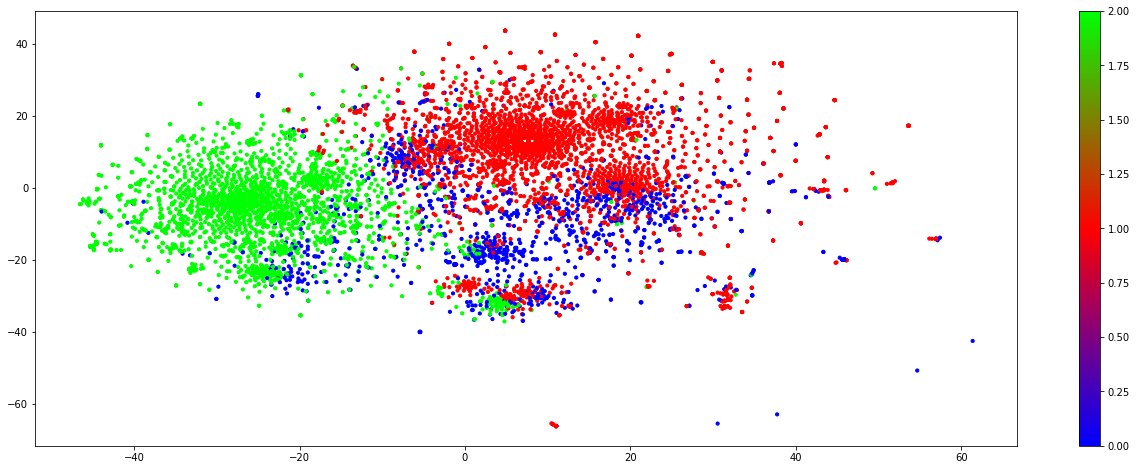

In [ ]:
plot_all(clean_df)

In [ ]:
def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

In [ ]:
show_cluster(corpus_df,1)

In [ ]:
show_cluster(clean_df,0)

 yo lo siento pero voy por la mitad del juego del calamar y tengo que decir que no me esta gustando ademas de decir que es muy machista
 lo bueno de ser tan basico es que puedes reciclar tu pasado disfraz de halloween solo compras otra mascara y listo casa de papel = juego del calamar
 acabo de cachar que el disfraz de una nina era de la muneca del juego del calamar y yo ayer pense que era la chilindrina
 y si me preguntan que de que me queria disfrazar pues del amor de tu vida pero bueno jaja mentiras de la munequita del juego de calamar
 por que no he visto a nadie disfrazado de el juego del calamar que no ven que me quiero reir un rato pendejos
 creo q tambien van a usar la serie de luis miguel para pegarle a macri y la serie you y la serie el juego del calamar y asi
 en el transmilenio venia un par de amigos hablando sobre la fiesta de disfraces y adivinaron el juego del calamar se creyeron super originales antes de entrarse que la mayoria esta pensando en ese disfraz
 como que mag

---